# Diameter reconstruction

Estimating diameters of image data can be tricky, depending on the orientation of the slices. In this repo, we provide image data of L5PTs. These neurons have a long and relatively thick dendrite, called the "apical" dendrite. The slices are cut perpendicular to this dendrite, making it hard to estimate its diameter. The difference between a corkscrewing apical dendrite and a straight and thick apical dendrite is virtually indistinguishable for most microscope resolutions. The other dendrites aren't particularly easy to reconstruct with diameters either.

This example notebook will guide the user through the module [dendrite_thickness](../../../dendrite_thickness/__init__.py). This module uses a rayburst algorithm to estimate the thickness of the dendrites at each location.

In [1]:
import Interface as I
from getting_started import getting_started_dir
DATA_DIR = I.os.path.join(getting_started_dir, "example_image_data")

trying to connect to distributed locking server {'config': {'hosts': 'somalogin02-hs:33333'}, 'type': 'zookeeper'}
success!
[INFO] ISF: Current version: heads/publish+0.g00fa8541.dirty
[INFO] ISF: Current pid: 277366
[INFO] mechanisms: Loading mechanisms:


--No graphics will be displayed.





[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 8.12.3, Interface: heads/publish+0.g00fa8541.dirty, PIL: 8.2.0, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, argparse: 1.1, attr: 20.3.0, backcall: 0.2.0, blake3: 0.3.3, blosc: 1.10.2, bluepyopt: 1.9.126, bottleneck: 1.3.2, cffi: 1.14.3, click: 7.1.2, cloudpickle: 1.6.0, colorama: 0.4.4, comm: 0.2.1, csv: 1.0, ctypes: 1.1.0, cycler: 0.10.0, cytoolz: 0.11.0, dash: 2.9.3, dask: 2.30.0, dateutil: 2.8.2, deap: 1.3, debugpy: 1.8.0, decimal: 1.70, decorator: 4.4.2, distributed: 2.30.1, distutils: 3.8.5, executing: 2.0.1, filelock: 3.0.12, flask: 1.1.2, flask_cors: 4.0.0, frozendict: 2.3.8, fsspec: 0.8.3, future: 0.18.2, gevent: 20.9.0, greenlet: 0.4.17, ipaddress: 1.0, ipykernel: 6.29.0, ipython_genutils: 0.2.0, ipywidgets: 7.5.1, itsdangerous: 1.1.0, jedi: 0.17.1, jinja2: 3.0.3, joblib: 1.3.2, json: 2.0.9, jupyter_client: 8.6.0, jupyter_core: 5.7.1, kazoo: 2.8.0, kiwisolver: 1.3.0, llvmlite: 0.34.0, loggin

In [2]:
am_folder_path = I.os.path.join(DATA_DIR, 'am_files')
tif_folder_path = I.os.path.join(DATA_DIR, 'image_files')
hoc_file_path = I.os.path.join(DATA_DIR, 'WR58_Cell5_L5TT_Final.hoc')
output_folder_path = I.os.path.join(DATA_DIR, 'output')
bijective_points_path = I.os.path.join(DATA_DIR, 'manual_landmarks.landmarkAscii')

# Image data

Let's start by loading in some image scan from the microscope and see what it looks like.

In [3]:
def downsample(img, factor):
    x, y = I.np.shape(img)
    cut_x, cut_y = x % factor, y % factor
    if cut_x:
        img = img[:-cut_x]
    if cut_y:
        img = img[:,:-cut_y]
    small_image = img.reshape(
        (x//factor, factor, y//factor, factor)).mean(3).mean(1)
    return small_image

In [4]:
img = I.plt.imread(I.os.path.join(tif_folder_path, 'S25_max_z_projection.tif'))
img.shape

(6622, 6656)

In [5]:
downsample_factor = 4
downscaled_img = downsample(img, downsample_factor)
downscaled_img.shape

(1655, 1664)

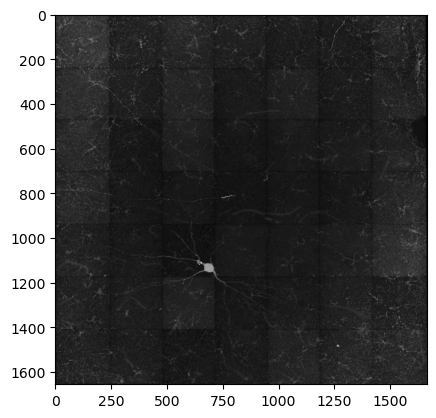

In [6]:
%matplotlib inline
fig = I.plt.figure()
I.plt.imshow(downscaled_img, cmap='Greys_r')
I.plt.show();

This is one slice from an entire image stack. The [dendrite_thickness](../../../dendrite_thickness/__init__.py) module assigns diameters to all dendrites slice per slice. As an example, we will assign diameters to this particular slice.

In [ ]:
from dendrite_thickness.thickness import pipeline
client=I.get_client()
# setup the thicnkess pipeline
p = pipeline.ExtractThicknessPipeline()

p.set_am_paths_by_folder(am_folder_path)
p.set_tif_paths_by_folder(tif_folder_path)
print("set_tif_paths_by_folder test. The first tif file is:")
print(p.tif_paths[0])
print(I.os.path.basename(p.am_paths[0]))

p.set_output_path(output_folder_path)
print("set_output_path test, should logger.info the output folder path")
print(p.set_output_path)

p.set_hoc_file(hoc_file_path)
print("set_hoc_file test, should logger.info the hoc file path")
print(p.hoc_file)

# p.set_thickness_extractor_parameters()
p.set_am_to_hoc_transformation_by_landmarkAscii(bijective_points_path)
p.set_client_for_parallelization(client=client)

set_tif_paths_by_folder test, should logger.info the first tif file
/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_image_data/image_files/S25_max_z_projection.tif
S25_final_downsampled_zscaled_1_19_aligned.am
set_output_path test, should logger.info the output folder path
<bound method ExtractThicknessPipeline.set_output_path of <dendrite_thickness.thickness.pipeline.ExtractThicknessPipeline object at 0x2b0e63507b80>>
Reading hoc file /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_image_data/WR58_Cell5_L5TT_Final.hoc
set_hoc_file test, should logger.info the hoc file path
/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_image_data/WR58_Cell5_L5TT_Final.hoc
<Client: 'tcp://10.102.2.81:38786' processes=24 threads=24, memory=2.36 TB>


In [ ]:
df = p.run()